In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

loading annotations into memory...
Done (t=1.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
A woman wearing a net on her head cutting a cake. 
A woman cutting a large white sheet cake.
A woman wearing a hair net cutting a large sheet cake.
there is a woman that is cutting a white cake
A woman marking a cake with the back of a chef's knife. 


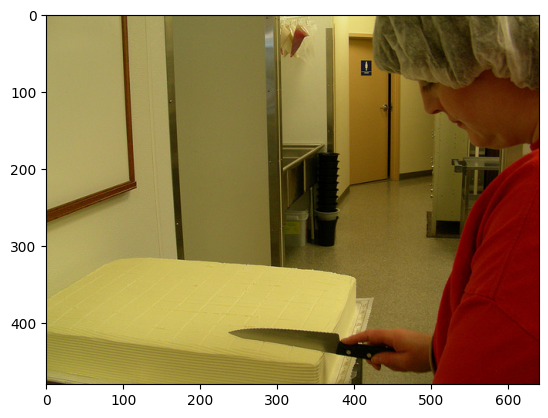

In [14]:
class CocoDataset:
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir
        self.train_directory = os.path.join(dataset_dir, 'train2017')
        self.val_directory = os.path.join(dataset_dir, 'val2017')
        self.train_annotations = os.path.join(dataset_dir, 'annotations', 'captions_train2017.json')
        self.val_annotations = os.path.join(dataset_dir, 'annotations', 'captions_val2017.json')

        self.train_coco = COCO(self.train_annotations)
        self.val_coco = COCO(self.val_annotations)
    
    def get_dataset(self, train=True):
        if train:
            coco = self.train_coco
        else:
            coco = self.val_coco

        img_ids = coco.getImgIds()
        images = coco.loadImgs(img_ids)
        captions = [coco.imgToAnns[img_id] for img_id in img_ids]

        return coco, [img['file_name'] for img in images], [[ann['caption'] for ann in anns] for anns in captions]

dataset_dir = 'coco2017'
coco = CocoDataset(dataset_dir)

_, train_images,train_captions = coco.get_dataset(train = True)
total_train_images = len(train_images)
_, val_images, val_captions = coco.get_dataset(train = False)
total_val_images = len(val_images)


# Fetch and display functions
def fetch_image(file_path, dimensions=None):
    image = Image.open(file_path)

    if dimensions is not None:
        image = image.resize(size=dimensions, resample=Image.LANCZOS)

    image_array = np.array(image)
    image_array = image_array / 255.0

    if image_array.ndim == 2:
        image_array = np.stack((image_array,) * 3, axis=-1)

    return image_array

def display_image(is_training,index):
    if(is_training):
        directory = coco.train_directory
        file_name = train_images[index]
        image_captions = train_captions[index]
    else:
        directory = coco.val_directory
        file_name = val_images[index]
        image_captions = val_captions[index]
    
    image_path = os.path.join(directory, file_name)

    # Display image and captions
    for caption in image_captions:
        print(caption)

    image = fetch_image(image_path)
    plt.imshow(image)
    plt.show()

# Display an example image from the training set
display_image(is_training=True, index=1)


In [3]:
pretrained_model = VGG16(weights='imagenet', include_top=True)
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K
import sys

In [5]:

import pickle

def cache(cache_path, fn, *args, **kwargs):
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    else:
        result = fn(*args, **kwargs)
        with open(cache_path, 'wb') as f:
            pickle.dump(result, f)
        return result


feature_layer = pretrained_model.get_layer('fc2')
model_transfer = Model(inputs=pretrained_model.input, outputs=feature_layer.output)

# Get image dimensions and feature vector size
image_dimensions = K.int_shape(pretrained_model.input)[1:3]
feature_vector_size = K.int_shape(feature_layer.output)[1]


In [6]:

# Utility functions
def display_progress(current_count, total_count):
    percent_complete = current_count / total_count
    status_message = '\r- prg status: {0:.1%}'.format(percent_complete)
    sys.stdout.write(status_message)
    sys.stdout.flush()

In [7]:
def process_image_batch(dataset_dir, file_names, batch_size=32):
    total_images = len(file_names)
    input_shape = (batch_size,) + image_dimensions + (3,)
    image_batch_array = np.zeros(shape=input_shape, dtype=np.float16)
    output_shape = (total_images, feature_vector_size)
    feature_vectors = np.zeros((total_images, feature_vector_size), dtype=np.float16)
    current_index = 0

    while current_index < total_images:
        display_progress(current_count=current_index, total_count=total_images)
        end_index = current_index + batch_size

        if end_index > total_images:
            end_index = total_images

        current_batch_size = end_index - current_index

        for i, file_name in enumerate(file_names[current_index:end_index]):
            image_path = os.path.join(dataset_dir, file_name)
            image = fetch_image(image_path, dimensions=image_dimensions)
            image_batch_array[i] = image

        feature_batch = model_transfer.predict(image_batch_array[:current_batch_size])
        feature_vectors[current_index:end_index] = feature_batch[:current_batch_size]
        current_index = end_index
        
    print()
    return feature_vectors

In [8]:
def process_training_images():
    print("Processing training images: {0}".format(len(train_images)))
    cache_file_path = os.path.join(coco.dataset_dir,"feature_vectors_train.pk1")
    feature_vectors = cache(cache_path=cache_file_path, fn=process_image_batch, dataset_dir=coco.train_directory, file_names=train_images)
    return feature_vectors

def process_validation_images():
    print("Processing validation images: {0}".format(len(val_images)))
    cache_file_path = os.path.join(coco.dataset_dir, "feature_vectors_val.pk1")
    feature_vectors = cache(cache_path=cache_file_path, fn=process_image_batch, dataset_dir=coco.val_directory, file_names=val_images)
    return feature_vectors

In [12]:
# Process training and validation images
# We waited like 8 hours for that but in end the print of this cell is deleted so there is no cool looking textes like the below cell
feature_vectors_train = process_training_images()
print("dtype:", feature_vectors_train.dtype)
print("shape:", feature_vectors_train.shape)

Processing training images: 118287
dtype: float16
shape: (118287, 4096)


In [15]:
feature_vectors_val = process_validation_images()
print("dtype:", feature_vectors_val.dtype)
print("shape:", feature_vectors_val.shape)

Processing validation images: 5000
1/1 [==============================] - 1s 950ms/step

dtype: float16
shape: (5000, 4096)


In [16]:
# Markers for captions
start_marker = 'xxxx'
end_marker = 'wwww'

def add_markers_to_captions(captions_nested_list):
    marked_captions = [[start_marker + caption + end_marker for caption in captions] for captions in captions_nested_list]
    return marked_captions

marked_train_captions = add_markers_to_captions(train_captions)
marked_train_captions[0]
train_captions[0]

['A man with a red helmet on a small moped on a dirt road. ',
 'Man riding a motor bike on a dirt road on the countryside.',
 'A man riding on the back of a motorcycle.',
 'A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. ',
 'A man in a red shirt and a red hat is on a motorcycle on a hill side.']

In [17]:

def flatten_captions(nested_captions_list):
    flat_captions_list = [caption for captions in nested_captions_list for caption in captions]
    return flat_captions_list

flat_train_captions = flatten_captions(marked_train_captions)
vocab_size = 10000

In [18]:
class ExtendedTokenizer(Tokenizer):
    def __init__(self,text_data, max_words=None):
        super().__init__(num_words=max_words)
        self.fit_on_texts(text_data)
        self.token_to_word_map = {index: word for word, index in self.word_index.items()}
    
    def token_to_word(self, token):
        return " " if token == 0 else self.token_to_word_map.get(token, "")
    
    def tokens_to_string(self, tokens):
        words = [self.token_to_word(token) for token in tokens if token != 0]
        return " ".join(words)
    
    def captions_to_tokens(self, nested_captions_list):
        token_sequences = [self.texts_to_sequences(captions) for captions in nested_captions_list]
        return token_sequences

tokenizer = ExtendedTokenizer(text_data=flat_train_captions,max_words=vocab_size)
start_token = tokenizer.word_index[start_marker.strip()]
end_token = tokenizer.word_index[end_marker.strip()]
train_tokens = tokenizer.captions_to_tokens(marked_train_captions)

In [19]:
def select_random_caption_tokens(indices):
    selected_tokens = []
    for index in indices:
        random_index = np.random.choice(len(train_tokens[index]))
        random_tokens = train_tokens[index][random_index]
        selected_tokens.append(random_tokens)
    return selected_tokens

In [20]:

def generate_batches(batch_size):
    while True:
        indices = np.random.randint(total_train_images, size=batch_size)
        feature_vectors = feature_vectors_train[indices]
        caption_tokens = select_random_caption_tokens(indices)
        num_tokens = [len(tokens) for tokens in caption_tokens]
        max_num_tokens = np.max(num_tokens)
        padded_tokens = pad_sequences(caption_tokens, maxlen=max_num_tokens, padding='post', truncating='post')
        decoder_input_data = padded_tokens[:, 0:-1]
        decoder_output_data = padded_tokens[:, 1:]
        x_data = {'decoder_input': decoder_input_data, 'feature_vectors_input': feature_vectors}
        y_data = {'decoder_output': decoder_output_data}
        yield (x_data, y_data)

In [21]:
batch_size = 32  
state_size = 512  
embedding_size = 256  
batch_gen = generate_batches(batch_size=batch_size)
batch = next(batch_gen)
batch_inputs = batch[0]
batch_outputs = batch[1]

num_train_captions = [len(captions) for captions in train_captions]
total_train_captions = np.sum(num_train_captions)
steps_per_epoch = int(total_train_captions / batch_size)

feature_vectors_input = Input(shape=(feature_vector_size,), name='feature_vectors_input')
decoder_feature_mapping = Dense(units=state_size, activation='tanh', name='decoder_feature_mapping')
decoder_input_sequence = Input(shape=(None,), name='decoder_input_sequence')
decoder_embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, name='decoder_embedding_layer')
decoder_gru_layer1 = GRU(units=state_size, return_sequences=True, name='decoder_gru_layer1')
decoder_gru_layer2 = GRU(units=state_size, return_sequences=True, name='decoder_gru_layer2')
decoder_gru_layer3 = GRU(units=state_size, return_sequences=True, name='decoder_gru_layer3')
decoder_output_layer = Dense(units=vocab_size, activation='softmax', name='decoder_output_layer')

In [22]:
def build_decoder(feature_vectors):
    initial_state = decoder_feature_mapping(feature_vectors)
    net = decoder_input_sequence
    net = decoder_embedding_layer(net)
    net = decoder_gru_layer1(net, initial_state=initial_state)
    net = decoder_gru_layer2(net, initial_state=initial_state)
    net = decoder_gru_layer3(net, initial_state=initial_state)
    decoder_output = decoder_output_layer(net)
    return decoder_output

decoder_output = build_decoder(feature_vectors=feature_vectors_input)
decoder_model = Model(inputs=[feature_vectors_input, decoder_input_sequence], outputs=[decoder_output])


1/1 [==============================] - 0s 37ms/step
Generated Caption: xxxx motocross crown weathervane directs directs xxxxpairs xxxxsunset xxxxsunset xxxxsunset cauliflower grabs cauliflower cauliflower size warmer movement pile pile lots cheesecake cheesecake cheesecake illuminating xxxxblender xxxxblender flightwwww flightwwww flightwwww wanting


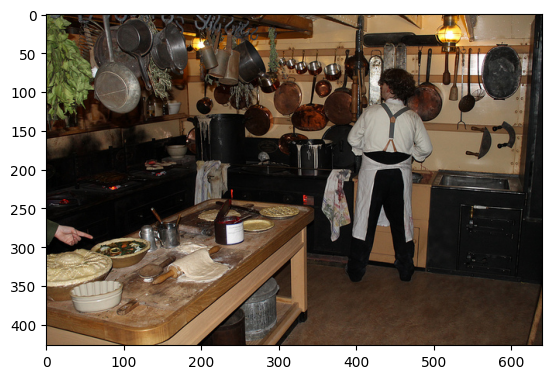

1/1 [==============================] - 0s 37ms/step
Generated Caption: xxxx motocross poses alcove directs xxxxpairs xxxxpairs xxxxpairs alot alot alot surgical surgical surgical surgical curling employee employee hut hut hut snackswwww throughout throughout throughout contrasting contrasting dirty dirty claus


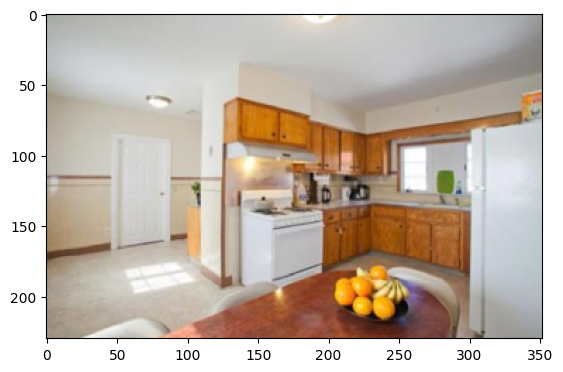

1/1 [==============================] - 0s 34ms/step
Generated Caption: xxxx motocross crown directs directs directs directs xxxxsunset xxxxsunset surgical surgical surgical surgical curling curling leather leather leather bike's bike's blowing counter counter counter girlfriend girlfriend bag xxxxeven xxxxeven visiting


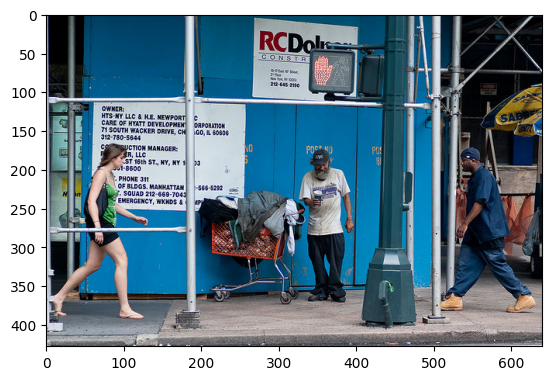

1/1 [==============================] - 0s 35ms/step
Generated Caption: xxxx dozen crown reins reins reins reins reins dishwwww dishwwww grabs dishwwww excited mass mass unpacked blowing blowing delivered delivered window projected projected tvs belongs belongs zebra's made asphalt asphalt


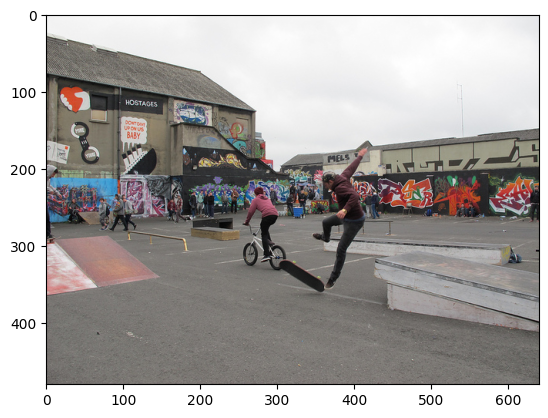

1/1 [==============================] - 0s 38ms/step
Generated Caption: xxxx motocross coupe coupe reins reins reins hillswwww hillswwww grabs grabs grabs artwork artwork artwork xxxxman xxxxman xxxxman cute bikers hats basket basket basket xxxxsun infield infield xxxxlong xxxxlong waiter


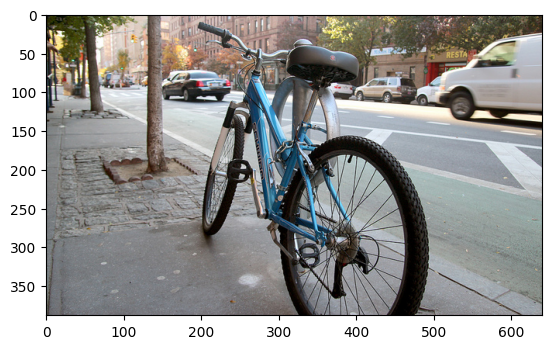

In [25]:
# test pictures

def generate_caption(image_path, max_tokens=30):
    
    image = fetch_image(image_path, dimensions=image_dimensions)
    image = np.expand_dims(image, axis=0)  
    feature_vector = model_transfer.predict(image)

    decoder_input = np.zeros((1, max_tokens), dtype=int)
    decoder_input[0, 0] = start_token

    for i in range(1, max_tokens):
        decoder_output = decoder_model.predict([feature_vector, decoder_input])
        token = np.argmax(decoder_output[0, i-1, :])
        
        decoder_input[0, i] = token
        if token == end_token:
            break

    caption = tokenizer.tokens_to_string(decoder_input[0])
    return caption

def display_image_with_caption(image_path):
    caption = generate_caption(image_path)
    print(f"Generated Caption: {caption}")
    
    image = fetch_image(image_path)
    plt.imshow(image)
    plt.show()

sample_images = [os.path.join(coco.val_directory, val_images[i]) for i in range(5)]
for image_path in sample_images:
    display_image_with_caption(image_path)
